In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
#import warnings
#warnings.filterwarnings("ignore")

import datetime

import torch
import torch.nn as nn

In [ ]:
#!pip install torchvision

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "MFC.TO"

# Define the desired date range for the historical data
start_date = "2017-06-26"
end_date = "2023-06-26"

# Download the historical data using yfinance
raw_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(raw_data)



[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2017-06-26  23.870001  23.889999  23.370001  23.530001  17.756609  3376900
2017-06-27  23.559999  23.740000  23.420000  23.709999  17.892445  3319800
2017-06-28  23.790001  24.090000  23.719999  24.080000  18.171658  4034300
2017-06-29  24.280001  24.530001  24.160000  24.490000  18.481056  6001200
2017-06-30  24.500000  24.590000  24.139999  24.309999  18.345221  4090900
...               ...        ...        ...        ...        ...      ...
2023-06-19  25.049999  25.190001  24.940001  25.090000  25.090000  3125500
2023-06-20  24.959999  25.049999  24.650000  24.780001  24.780001  4608800
2023-06-21  24.709999  24.760000  24.600000  24.620001  24.620001  4030500
2023-06-22  24.520000  24.580000  24.270000  24.290001  24.290001  6718400
2023-06-23  24.170000  24.20999

In [ ]:
raw_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1.505000e+03
mean,23.641641,23.852532,23.438365,23.639123,20.346509,6.189506e+06
std,2.585487,2.554027,2.628738,2.598476,2.952839,4.599209e+06
min,13.100000,13.760000,12.580000,12.970000,10.896906,4.667000e+05
25%,22.469999,22.709999,22.250000,22.480000,18.481056,3.256300e+06
50%,24.200001,24.389999,24.040001,24.180000,20.269827,4.789500e+06
75%,25.350000,25.530001,25.160000,25.379999,22.441160,7.610300e+06
max,27.799999,28.090000,27.500000,27.889999,26.997684,3.924180e+07


In [ ]:
raw_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
raw_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
raw_data.reset_index(inplace=True)

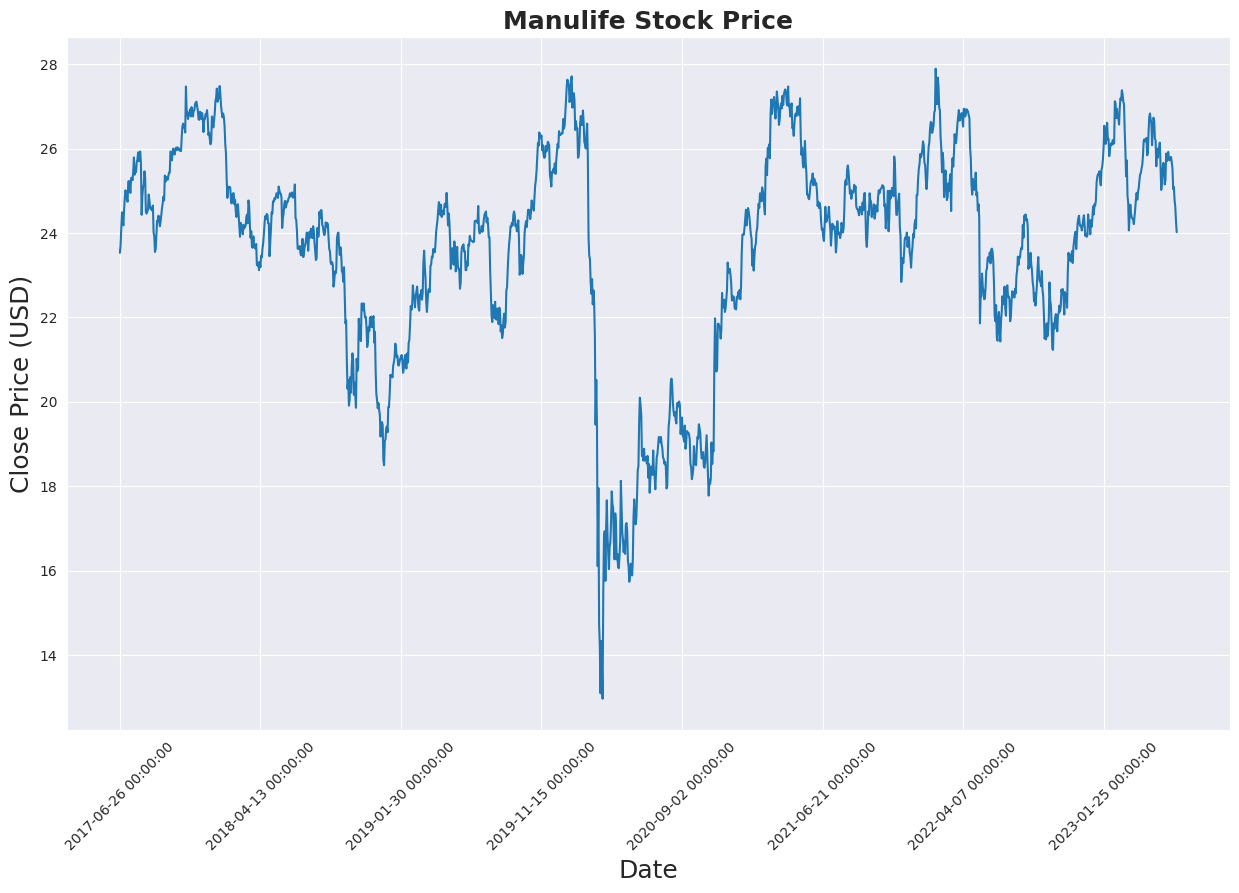

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(raw_data[['Close']])
plt.xticks(range(0,raw_data.shape[0],200),raw_data['Date'].loc[::200],rotation=45)
plt.title("Manulife Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [ ]:
price = raw_data[['Close']]

### Preprocessing data
Change raw feature vectors. Use `MinMaxScaler` to scaling features between minimum (-1) and maximum (1) values.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-11-77e3f41ac3d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
price['Close']

0       0.415550
1       0.439678
2       0.489276
3       0.544236
4       0.520107
          ...   
1500    0.624665
1501    0.583110
1502    0.561662
1503    0.517426
1504    0.481233
Name: Close, Length: 1505, dtype: float64

Define the window width of the analysis. The use of `prior time steps` to predict the `next time step` is called the **sliding window** method.

<img src = "https://www.learntek.org/blog/wp-content/uploads/2018/11/Screenshot-155.png" width = '250'>

Then split data into train and test sets.

In [ ]:
def split_data(stock, lookback):
  data_raw = stock.to_numpy()     # Create to numpy a data_raw
  data = []

  # Create all possible sequences of length seq_len
  for index in range(len(data_raw)-lookback):
    data.append(data_raw[index: index+lookback])

  data = np.array(data)
  test_set_size = int(np.round(0.2*data.shape[0]))
  train_set_size = data.shape[0] - test_set_size

  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]

  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]

  return [x_train, y_train, x_test, y_test]

Choose sequence length

<img src = "https://i.stack.imgur.com/Nc5PO.png" width = '420'>

Transform train and test sets into `tensors`, which is the basic structure for building a PyTorch model.

In [ ]:
lookback = 20     # squence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1188, 19, 1)
y_train.shape =  (1188, 1)
x_test.shape =  (297, 19, 1)
y_test.shape =  (297, 1)


In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

Define some common values for both models regarding the layers

<img src = "https://blog.floydhub.com/content/images/2019/06/Slide19.JPG" width = '600'>


In [ ]:
input_dim = 1      # represents the size of the input at each time step, e.g. input of dimension 5 will look like this [1, 3, 8, 2, 3]
hidden_dim = 32    # represents the size of the hidden state and cell state at each time step
num_layers = 2     # the number of LSTM layers stacked on top of each other
output_dim = 1     # represents the size of the output at each time step
num_epochs = 100   # how many times will the input return the whole batch

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

###Define the Model

Set the [criterion](https://nn.readthedocs.io/en/latest/criterion/index.html) (given an input and a target, they compute a gradient according to a given loss function.), and the [optimiser](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) (process of adjusting model parameters to reduce model error in each training step).

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train the model
Train the model over 100 epochs

In [ ]:
import time

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for epoch in range(num_epochs):
  y_train_pred = model(x_train)

  loss = criterion(y_train_pred, y_train_lstm)
  print('Epoch ', epoch, 'MSE: ', loss.item())
  hist[epoch] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

training_time = time.time() - start_time
print('Training time: {}'.format(training_time))

Epoch  0 MSE:  0.27449268102645874
Epoch  1 MSE:  0.2002227008342743
Epoch  2 MSE:  0.14371919631958008
Epoch  3 MSE:  0.12875927984714508
Epoch  4 MSE:  0.13963551819324493
Epoch  5 MSE:  0.11075995117425919
Epoch  6 MSE:  0.09391359239816666
Epoch  7 MSE:  0.08682658523321152
Epoch  8 MSE:  0.07458323985338211
Epoch  9 MSE:  0.049601972103118896
Epoch  10 MSE:  0.03376099094748497
Epoch  11 MSE:  0.037178926169872284
Epoch  12 MSE:  0.017237255349755287
Epoch  13 MSE:  0.030091263353824615
Epoch  14 MSE:  0.02781938575208187
Epoch  15 MSE:  0.016672983765602112
Epoch  16 MSE:  0.018017003312706947
Epoch  17 MSE:  0.01814153417944908
Epoch  18 MSE:  0.012182651087641716
Epoch  19 MSE:  0.010965880006551743
Epoch  20 MSE:  0.013621731661260128
Epoch  21 MSE:  0.015440987423062325
Epoch  22 MSE:  0.014669598080217838
Epoch  23 MSE:  0.01233265083283186
Epoch  24 MSE:  0.0106003163382411
Epoch  25 MSE:  0.010893763974308968
Epoch  26 MSE:  0.012138762511312962
Epoch  27 MSE:  0.011776772

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

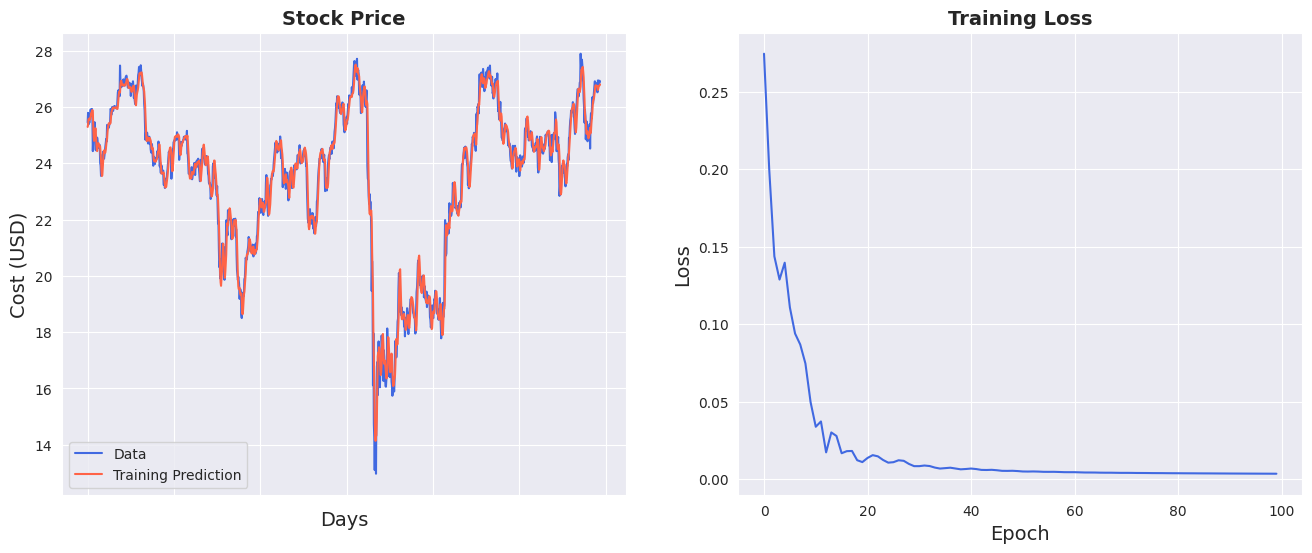

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x=original.index, y=original[0], label='Data', color='royalblue')
ax = sns.lineplot(x=predict.index, y=predict[0], label='Training Prediction', color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

### Prediction

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Make predictions
y_test_pred = model(x_test)

# Invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# Calculate root MSE
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train score {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test score {testScore:.2f} RMSE')

lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train score 0.44 RMSE
Test score 0.41 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2,
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

The model behaves very well with the training set, and also has a good performance with the test set.


### GRU

[Gated Recurrent Unit (GRU)](https://blog.floydhub.com/gru-with-pytorch/) uses gating mechanisms to control and manage the flow of information between cells in the neural network.

<img src = "https://blog.floydhub.com/content/images/2019/07/image17-1.jpg" width = '420'>



In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2000165730714798
Epoch  1 MSE:  0.11384650319814682
Epoch  2 MSE:  0.12062044441699982
Epoch  3 MSE:  0.08723914623260498
Epoch  4 MSE:  0.06138842552900314
Epoch  5 MSE:  0.0520276203751564
Epoch  6 MSE:  0.028562121093273163
Epoch  7 MSE:  0.007348175626248121
Epoch  8 MSE:  0.028564022853970528
Epoch  9 MSE:  0.017122304067015648
Epoch  10 MSE:  0.022040849551558495
Epoch  11 MSE:  0.020031597465276718
Epoch  12 MSE:  0.007922414690256119
Epoch  13 MSE:  0.004402186721563339
Epoch  14 MSE:  0.009303056634962559
Epoch  15 MSE:  0.012307172641158104
Epoch  16 MSE:  0.01104934886097908
Epoch  17 MSE:  0.009661859832704067
Epoch  18 MSE:  0.009624622762203217
Epoch  19 MSE:  0.00919265951961279
Epoch  20 MSE:  0.007038689684122801
Epoch  21 MSE:  0.004234691616147757
Epoch  22 MSE:  0.0032524459529668093
Epoch  23 MSE:  0.0047195241786539555
Epoch  24 MSE:  0.005991277284920216
Epoch  25 MSE:  0.005498521961271763
Epoch  26 MSE:  0.004985704552382231
Epoch  27 MSE:  0.0

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

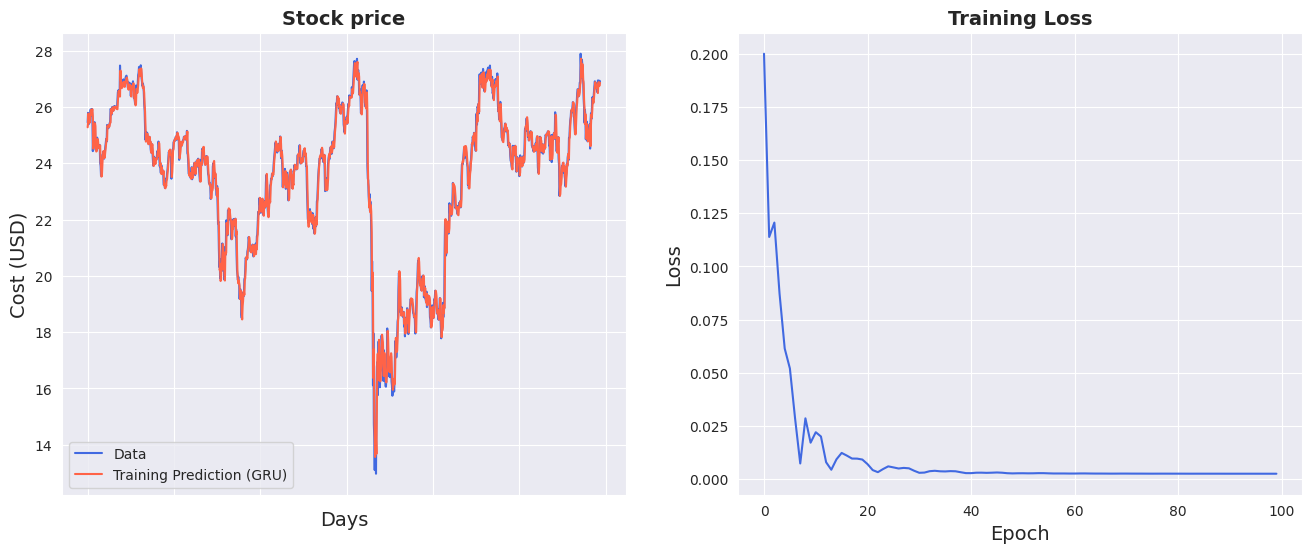

In [ ]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

Training step is exactly the same, and the results we achieve are somehow similar as well.

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 0.37 RMSE
Test Score: 0.34 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
# The result does not work in colab. I run it in jupiter then send to colab.
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.438513,0.374976
Test RMSE,0.405953,0.339471
Train Time,13.204295,10.734226


GRU performance is better than LSTM reached a lower `mean square error` (in training, and most importantly, in the test set) and in speed.


In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import chart_studio.plotly as py
import chart_studio

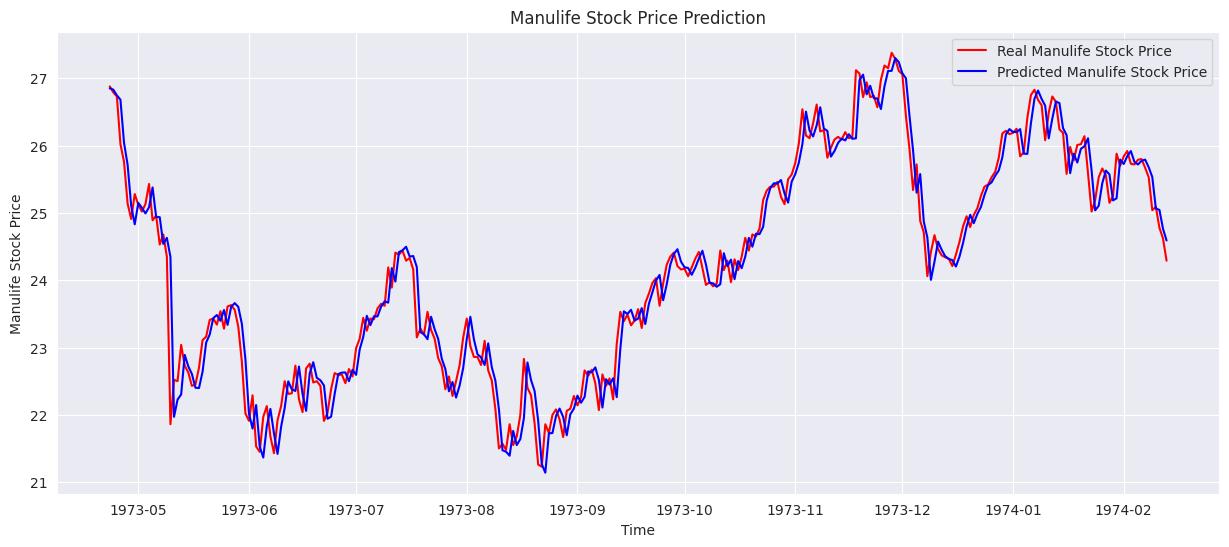

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(price[len(price)-len(y_test):].index, y_test, color = 'red', label = 'Real Manulife Stock Price')
axes.plot(price[len(price)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Manulife Stock Price')

plt.title('Manulife Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Manulife Stock Price')
plt.legend()
plt.savefig('manulife_pred.png')
plt.show()